# NLP Answers

- **Answer Set**: No. 01
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Basics

In this section we will done some basic steps:

### Libraries

Before begin, we must import these required libraries:

In [1]:
import warnings

import math as math
import hazm as hazm

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import sklearn.utils as skutils
import sklearn.pipeline as skpipeline
import sklearn.preprocessing as skprocessing
import sklearn.model_selection as skselection
import sklearn.feature_extraction.text as sktext

warnings.filterwarnings("ignore", category=UserWarning)
sk.set_config(display="diagram")

### Dataset

Now we will load `Hamshahri v2` corpus and split it into `TestSet` and `TrainSet`:

In [2]:
corpus = hazm.HamshahriReader(root="../lib/HAM2")

documents = filter(
    lambda doc: "Literature and Art" in doc["categories_en"],
    corpus.docs()
)

sentences = sum([
    hazm.sent_tokenize(next(documents)["text"])
    for _ in range(100)
], [])

data_frame = pd.DataFrame(sentences, columns=["sentence"])
data_frame = skutils.shuffle(data_frame)

data_features = data_frame.filter(["sentence"], axis=1).to_numpy()
data_labels = data_frame.filter(["category_en"], axis=1).to_numpy()

train_features, test_features, train_labels, test_labels = skselection.train_test_split(
    data_features, 
    data_labels, 
    test_size=0.2, 
    random_state=313
)

data_features = data_features.flatten()
train_features = train_features.flatten()
test_features = test_features.flatten()

data_frame

,sentence
1033,بسياري از ما منتظر معجزه هستيم.
17,اگر به اين ذهنيت با خشونت حمله شود، آسايش براي...
735,Picaro edn)Big Sun..
1289,وي شاعر، عارف و داستان نويس صاحب نام است و از ...
1346,نمي دانم تا چه حد موفق شده باشم كه به اين منظ...
...,...
677,از ساعت 17 تا 20.
961,بهرام صادقي مزيدي كه دررشته تئاتر تحصيل مي كند...
414,ديگر آنكه، كودكاني در آنجا تحت تاثير جو نامنا...
947,قصه كوه جواهر هم اين امكان را مي داد كه گفتگو ...


### Analysis

Now, we will analyse `DataSet`, `TrainSet`, `TestSet` and will find these parameters:

- **Sentence Count**: Number of sentences
- **Word Count**: Number of words
- **Unique Word Count**: Number of unique words
- **Average Word/Sentence**: Average number of words per sentence

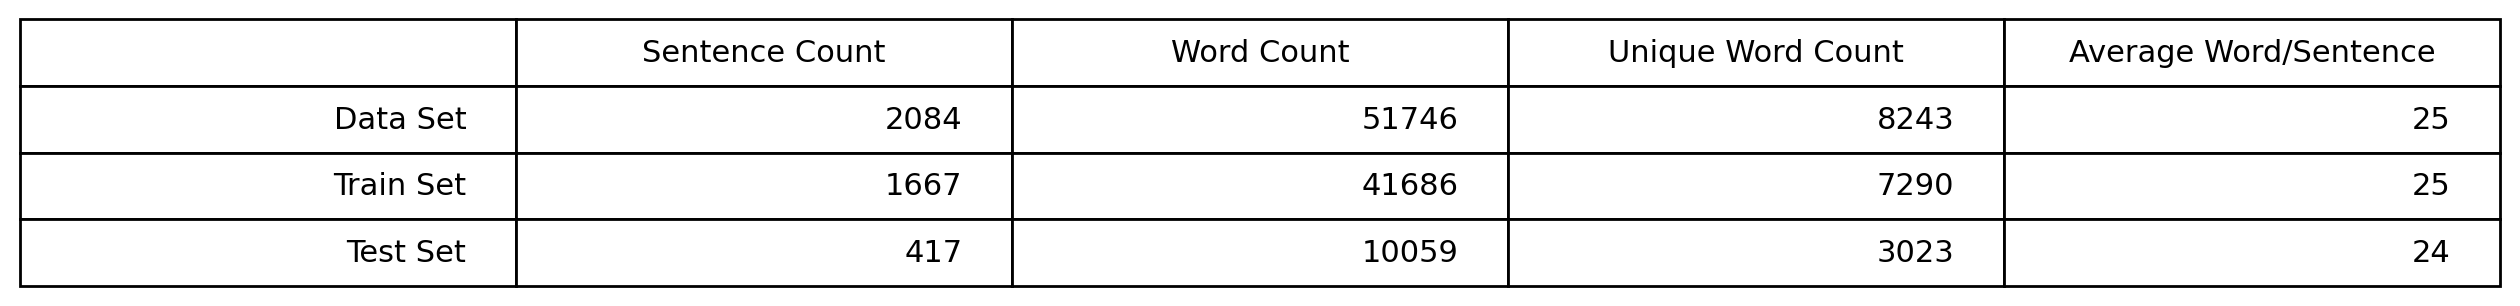

In [4]:
data_words = hazm.word_tokenize('. '.join(data_features))
train_words = hazm.word_tokenize('. '.join(train_features))
test_words = hazm.word_tokenize('. '.join(test_features))

plt.figure(figsize=(8, 1), dpi=200)
table = plt.table(cellText=[
    [
        "Data Set",
        len(data_features),
        len(data_words),
        len(set(data_words)),
        round(len(data_words) / len(data_features))
    ],
    [
        "Train Set",
        len(train_features),
        len(train_words),
        len(set(train_words)),
        round(len(train_words) / len(train_features))
    ],
    [
        "Test Set",
        len(test_features),
        len(test_words),
        len(set(test_words)),
        round(len(test_words) / len(test_features))
    ]
], colLabels=["", "Sentence Count", "Word Count", "Unique Word Count", "Average Word/Sentence"], loc="center")
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 2)
plt.axis("off")
plt.show()

---

## Problem

Before the begin, first we must implement a `Scikit-Learn Transformer` class which applies the `NGram Vectorization` over a set of sentences

We will use **hazm** library inorder to apply these preprocessing steps:

- **Stemmer**
- **Normalizer**
- **Lemmatizer**
- **Stop Words Removal**

Next, we will implement `perplexity()` and `probability()` methods inorder to compute model accuracy

In [76]:
class NGramVectorizer(sktext.CountVectorizer):
    def __init__(self, ngram_range=(1, 1), max_features=None, max_df=1.0, min_df=1):
        super().__init__(
            tokenizer=self._tokenizer,
            ngram_range=ngram_range,
            max_features=max_features,
            max_df=max_df,
            min_df=min_df
        )

        self._stemmer = hazm.Stemmer()
        self._normalizer = hazm.Normalizer()
        self._lemmatizer = hazm.Lemmatizer()
        self._stop_words = hazm.stopwords_list("../lib/PersianStopWords.txt")
    
    def _tokenizer(self, sentence):
        return [
            self._lemmatizer.lemmatize(self._normalizer.normalize(self._stemmer.stem(word)))
            for word in hazm.word_tokenize(sentence)
            if word not in self._stop_words
        ]

    def fit(self, X, y=None):
        self.frequency_ = np.asarray(self.fit_transform(X, y).sum(axis=0)).reshape(-1)
        self.ngrams_ = self.frequency_.sum()
        return self

    def probability(self, ngram):
        # Laplace smoothing
        if ngram == "":
            return 1
        if ngram not in self.vocabulary_:
            return 1 / (self.ngrams_ + len(self.frequency_))
        return (self.frequency_[self.vocabulary_[ngram]] + 1) / (self.ngrams_ + len(self.frequency_))

    def perplexity(self, sentence):
        tokens = self._tokenizer(sentence)
        probabilities = [
            self.probability(' '.join(tokens[max(0, i - self.ngram_range[1]) : i + 1])) /
            self.probability(' '.join(tokens[max(0, i - self.ngram_range[1]) : i]))
            for i in range(len(tokens))
        ]
        if len(tokens) <= 0:
            return 0
        return math.exp((-1 / len(tokens)) * sum(map(math.log, probabilities)))

### Model Training

Now, we can use the predefined transformer inorder to train `N-Gram Models` and storing them in models array, then we will find the most frequent words in corpus

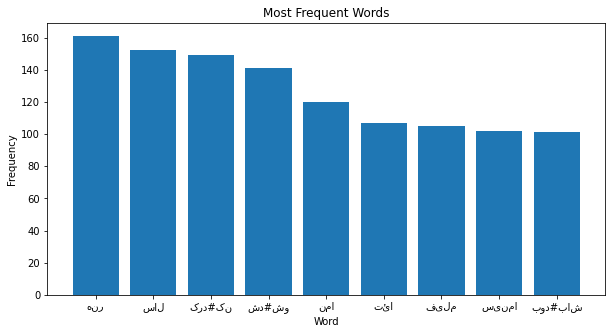

In [77]:
models = []
for i in range(1):
    models.append(
        NGramVectorizer(
            ngram_range=(1, i + 1),
            # max_features=500,
            # max_df=1.0,
            # min_df=1,
        ).fit(train_features)
    )

frequents = (-models[0].frequency_).argsort()[1:10]
frequencies = models[0].frequency_[frequents]
words = [
    [key for key, val in models[0].vocabulary_.items() if val == idx][0]
    for idx in frequents
]

plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Most Frequent Words")
plt.show()

### Model Testing

Now, we can use our pre-trained models and find the average perplexity on test set

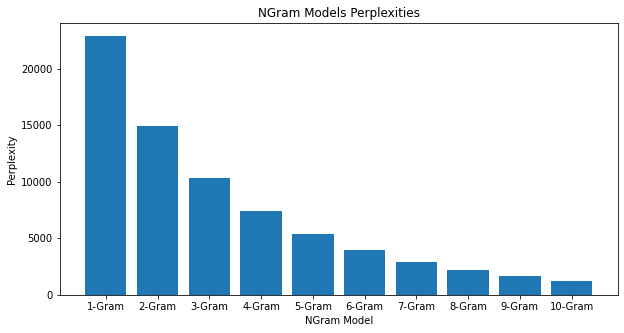

In [21]:
labels = [f"{i + 1}-Gram" for i in range(10)]
perplexities = [models[i].perplexity(''.join(test_features)) for i in range(10)]


plt.figure(figsize=(10, 5))
plt.bar(labels, perplexities)
plt.xlabel("NGram Model")
plt.ylabel("Perplexity")
plt.title("NGram Models Perplexities")
plt.show()

---